Acquire data from the cloud database.

You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.

Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid. - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) - Only include properties that have a latitude and longitude value.

In [2]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from env import host, user, password

In [4]:
#URL function
def get_db_url(host, username, password, db):
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'

In [5]:
db = 'zillow'

url = get_db_url(host, user, password, db)

In [7]:
# write the SQL query
query = '''
        SELECT prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        land.propertylandusedesc,
        story.storydesc,
        type.typeconstructiondesc
        FROM properties_2017 prop
        JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid
            ) pred USING(parcelid)
        JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                          AND pred.max_transactiondate = predictions_2017.transactiondate
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
        '''

In [8]:
#Read in the dataframe
df = pd.read_sql(query, url)

df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,None,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,None,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,None,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,None,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,781532,12095076,1.0,NaN,NaN,3.0,4.0,None,9.0,3.0,...,6.037461e+13,-0.001011,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,52319.0,1.496888e+06,8.594310e+05,3.490000e+02,7.575810e+05,1.500095e+06,2.241248e+06,2.982270e+06
parcelid,52319.0,1.299682e+07,3.350951e+06,1.071186e+07,1.151017e+07,1.257825e+07,1.413036e+07,1.676878e+08
airconditioningtypeid,13615.0,2.439589e+00,3.847925e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,70.0,7.100000e+00,2.665670e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,47.0,6.789787e+02,7.118252e+02,3.800000e+01,2.635000e+02,5.120000e+02,8.095000e+02,3.560000e+03
bathroomcnt,52319.0,2.300015e+00,1.022816e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,52319.0,3.300770e+00,9.475632e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
buildingqualitytypeid,33654.0,6.264961e+00,1.716328e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,52184.0,2.305276e+00,1.018076e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,389.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52319 non-null  int64  
 1   parcelid                      52319 non-null  int64  
 2   airconditioningtypeid         13615 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52319 non-null  float64
 6   bedroomcnt                    52319 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         33654 non-null  float64
 9   calculatedbathnbr             52184 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4371 non-null   float64
 12  calculatedfinishedsquarefeet  52238 non-null  float64
 13  f

In [14]:
df.shape

(52319, 68)

(-2.0, 2.0)

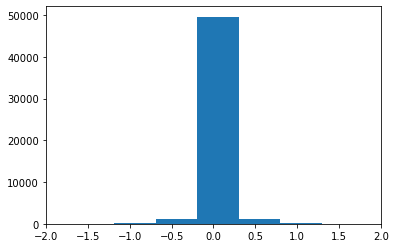

In [13]:
#Distribution of target variable
plt.hist(x=df['logerror'], bins=20)
plt.xlim(-2, 2)

Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [15]:
#Define function to calculate number and percent of values missing from each column
def null_counter(df):
    
    new_columns = ['name', 'num_rows_missing', 'pct_rows_missing']
    
    new_df = pd.DataFrame(columns=new_columns)
    
    for col in list(df.columns):
        num_missing = df[col].isna().sum()
        pct_missing = num_missing / df.shape[0]
        
        add_df = pd.DataFrame([{'name': col, 'num_rows_missing': num_missing,
                               'pct_rows_missing': pct_missing}])
        
        new_df = pd.concat([new_df, add_df], axis=0)
        
    new_df.set_index('name', inplace=True)
    
    return new_df

In [16]:
#Execute my function and verify the results
null_df = null_counter(df)

null_df.head()

,num_rows_missing,pct_rows_missing
name,,
id,0,0.0
parcelid,0,0.0
airconditioningtypeid,38704,0.739769
architecturalstyletypeid,52249,0.998662
basementsqft,52272,0.999102


Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.

In [17]:
df[df['calculatedfinishedsquarefeet'] == 0]


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc


In [18]:
df[df['lotsizesquarefeet'] == 0]

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc


Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

In [19]:
def null_dropper(df, prop_required_column, prop_required_row):
    
    prop_null_column = 1 - prop_required_column
    
    for col in list(df.columns):
        
        null_sum = df[col].isna().sum()
        null_pct = null_sum / df.shape[0]
        
        if null_pct > prop_null_column:
            df.drop(columns=col, inplace=True)
            
    row_threshold = int(prop_required_row * df.shape[1])
    
    df.dropna(axis=0, thresh=row_threshold, inplace=True)
    
    return df

In [20]:
clean_df = null_dropper(df, 0.75, 0.75)

clean_df.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,1727539,14297519,3.5,4.0,3.5,3100.0,3100.0,6059.0,3.0,33634931.0,...,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,Single Family Residential
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential
3,2288172,12177905,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential
4,781532,12095076,3.0,4.0,3.0,2962.0,2962.0,6037.0,3.0,34145202.0,...,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Single Family Residential


In [21]:
clean_df.shape

(52317, 29)

Encapsulate your work inside of functions in a wrangle_zillow.py module.

Acquire data from the customers table in the mall_customers database.

In [22]:
mall_query = '''
             SELECT *
             FROM customers
             '''
mall_db = 'mall_customers'

mall_url = get_db_url(host, user, password, mall_db)

In [23]:
mall_df = pd.read_sql(mall_query, mall_url)

mall_df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Summarize the data (include distributions and descriptive statistics).

In [25]:
mall_df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


(array([16., 20., 10., 17., 35., 37., 11., 24., 14., 16.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <BarContainer object of 10 artists>)

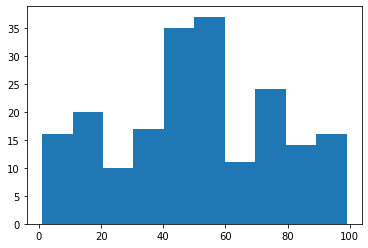

In [26]:
plt.hist(mall_df['spending_score'])

In [27]:
mall_df.isnull().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

Detect outliers using IQR.

In [29]:
age_q1, age_q3 = mall_df['age'].quantile([0.25, 0.75])

In [32]:
IQR = age_q3 - age_q1
IQR

20.25

Split data into train, validate, and test.

In [33]:
seed = 42

mall_train, test_val = train_test_split(mall_df, train_size=0.7,
                                   random_state=seed)

mall_test, mall_val = train_test_split(test_val, train_size=0.5,
                                       random_state=seed)

mall_train.shape, mall_val.shape, mall_test.shape

((140, 5), (30, 5), (30, 5))

Encode categorical columns using a one hot encoder (pd.get_dummies).

In [34]:
pd.get_dummies(mall_train)

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male
169,170,32,87,63,0,1
97,98,27,60,50,1,0
31,32,21,30,73,1,0
12,13,58,20,15,1,0
35,36,21,33,81,1,0
...,...,...,...,...,...,...
106,107,66,63,50,1,0
14,15,37,20,13,0,1
92,93,48,60,49,0,1
179,180,35,93,90,0,1


In [35]:
mall_train = pd.get_dummies(mall_train)

mall_train.drop(columns=['gender_Male'], inplace=True)

mall_train.head()

,customer_id,age,annual_income,spending_score,gender_Female
169,170,32,87,63,0
97,98,27,60,50,1
31,32,21,30,73,1
12,13,58,20,15,1
35,36,21,33,81,1


Handles missing values.

In [36]:
mall_train.isnull().sum()

customer_id       0
age               0
annual_income     0
spending_score    0
gender_Female     0
dtype: int64

Scaling

In [37]:
MinMax = MinMaxScaler()

mall_train[['age', 'annual_income']] = MinMax.fit_transform(mall_train[['age',
                                                                     'annual_income']])

mall_train.head()

,customer_id,age,annual_income,spending_score,gender_Female
169,170,0.269231,0.590164,63,0
97,98,0.173077,0.368852,50,1
31,32,0.057692,0.122951,73,1
12,13,0.769231,0.040984,15,1
35,36,0.057692,0.147541,81,1
